```
Licensed to the Apache Software Foundation (ASF) under one
or more contributor license agreements.  See the NOTICE file
distributed with this work for additional information
regarding copyright ownership.  The ASF licenses this file
to you under the Apache License, Version 2.0 (the
"License"); you may not use this file except in compliance
with the License.  You may obtain a copy of the License at
  http://www.apache.org/licenses/LICENSE-2.0
Unless required by applicable law or agreed to in writing,
software distributed under the License is distributed on an
"AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY
KIND, either express or implied.  See the License for the
specific language governing permissions and limitations
under the License.
```

In [1]:
import os

import geopandas as gpd
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, expr, when

from sedona.register import SedonaRegistrator
from sedona.utils import SedonaKryoRegistrator, KryoSerializer
from sedona.core.formatMapper.shapefileParser import ShapefileReader
from sedona.utils.adapter import Adapter
from sedona.core.enums import GridType
from sedona.core.enums import IndexType
from sedona.core.spatialOperator import JoinQueryRaw

## Setup Sedona environment

In [2]:
spark = SparkSession.builder.\
        master("local[*]").\
        appName("SedonaSQL-Example").\
        config("spark.serializer", KryoSerializer.getName).\
        config("spark.kryo.registrator", SedonaKryoRegistrator.getName) .\
        config("spark.jars.packages", "org.apache.sedona:sedona-spark-shaded-3.0_2.12:1.4.0,org.datasyslab:geotools-wrapper:1.4.0-28.2") .\
        getOrCreate()
SedonaRegistrator.registerAll(spark)
sc = spark.sparkContext
sc.setSystemProperty("sedona.global.charset", "utf8")

21/10/08 19:58:06 WARN Utils: Your hostname, Jia-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 192.168.0.34 instead (on interface en0)
21/10/08 19:58:06 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


:: loading settings :: url = jar:file:/Users/jiayu/Downloads/spark-3.1.2-bin-hadoop3.2/jars/ivy-2.4.0.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /Users/jiayu/.ivy2/cache
The jars for the packages stored in: /Users/jiayu/.ivy2/jars
org.apache.sedona#sedona-python-adapter-3.0_2.12 added as a dependency
org.datasyslab#geotools-wrapper added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-15133089-5026-4f0c-8975-860f756f148d;1.0
	confs: [default]
	found org.apache.sedona#sedona-python-adapter-3.0_2.12;1.1.0-incubating in central
	found org.locationtech.jts#jts-core;1.18.0 in central
	found org.wololo#jts2geojson;0.16.1 in central
	found com.fasterxml.jackson.core#jackson-databind;2.12.2 in central
	found com.fasterxml.jackson.core#jackson-annotations;2.12.2 in central
	found com.fasterxml.jackson.core#jackson-core;2.12.2 in central
	found org.apache.sedona#sedona-core-3.0_2.12;1.1.0-incubating in central
	found org.apache.sedona#sedona-sql-3.0_2.12;1.1.0-incubating in central
	found org.datasyslab#geotools-wrapper;1.1.0-25.2-RC1 in central
:: resolution report :: resolve 3

## Read countries shapefile into a Sedona DataFrame 
Data link: https://www.naturalearthdata.com/downloads/50m-cultural-vectors/

In [3]:
countries = ShapefileReader.readToGeometryRDD(sc, "data/ne_50m_admin_0_countries_lakes/")
countries_df = Adapter.toDf(countries, spark)
countries_df.createOrReplaceTempView("country")
countries_df.printSchema()

root
 |-- geometry: geometry (nullable = true)
 |-- featurecla: string (nullable = true)
 |-- scalerank: string (nullable = true)
 |-- LABELRANK: string (nullable = true)
 |-- SOVEREIGNT: string (nullable = true)
 |-- SOV_A3: string (nullable = true)
 |-- ADM0_DIF: string (nullable = true)
 |-- LEVEL: string (nullable = true)
 |-- TYPE: string (nullable = true)
 |-- ADMIN: string (nullable = true)
 |-- ADM0_A3: string (nullable = true)
 |-- GEOU_DIF: string (nullable = true)
 |-- GEOUNIT: string (nullable = true)
 |-- GU_A3: string (nullable = true)
 |-- SU_DIF: string (nullable = true)
 |-- SUBUNIT: string (nullable = true)
 |-- SU_A3: string (nullable = true)
 |-- BRK_DIFF: string (nullable = true)
 |-- NAME: string (nullable = true)
 |-- NAME_LONG: string (nullable = true)
 |-- BRK_A3: string (nullable = true)
 |-- BRK_NAME: string (nullable = true)
 |-- BRK_GROUP: string (nullable = true)
 |-- ABBREV: string (nullable = true)
 |-- POSTAL: string (nullable = true)
 |-- FORMAL_EN: st

21/10/08 19:58:13 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


## Read airports shapefile into a Sedona DataFrame 
Data link: https://www.naturalearthdata.com/downloads/50m-cultural-vectors/

In [4]:
airports = ShapefileReader.readToGeometryRDD(sc, "data/ne_50m_airports/")
airports_df = Adapter.toDf(airports, spark)
airports_df.createOrReplaceTempView("airport")
airports_df.printSchema()

root
 |-- geometry: geometry (nullable = true)
 |-- scalerank: string (nullable = true)
 |-- featurecla: string (nullable = true)
 |-- type: string (nullable = true)
 |-- name: string (nullable = true)
 |-- abbrev: string (nullable = true)
 |-- location: string (nullable = true)
 |-- gps_code: string (nullable = true)
 |-- iata_code: string (nullable = true)
 |-- wikipedia: string (nullable = true)
 |-- natlscale: string (nullable = true)



## Run Spatial Join using SQL API

In [5]:
result = spark.sql("SELECT c.geometry as country_geom, c.NAME_EN, a.geometry as airport_geom, a.name FROM country c, airport a WHERE ST_Contains(c.geometry, a.geometry)")

## Run Spatial Join using RDD API

In [6]:
airports_rdd = Adapter.toSpatialRdd(airports_df, "geometry")
# Drop the duplicate name column in countries_df
countries_df = countries_df.drop("NAME")
countries_rdd = Adapter.toSpatialRdd(countries_df, "geometry")

airports_rdd.analyze()
countries_rdd.analyze()

# 4 is the num partitions used in spatial partitioning. This is an optional parameter
airports_rdd.spatialPartitioning(GridType.KDBTREE, 4)
countries_rdd.spatialPartitioning(airports_rdd.getPartitioner())

buildOnSpatialPartitionedRDD = True
usingIndex = True
considerBoundaryIntersection = True
airports_rdd.buildIndex(IndexType.QUADTREE, buildOnSpatialPartitionedRDD)

result_pair_rdd = JoinQueryRaw.SpatialJoinQueryFlat(airports_rdd, countries_rdd, usingIndex, considerBoundaryIntersection)

result2 = Adapter.toDf(result_pair_rdd, countries_rdd.fieldNames, airports.fieldNames, spark)

result2.createOrReplaceTempView("join_result_with_all_cols")
# Select the columns needed in the join
result2 = spark.sql("SELECT leftgeometry as country_geom, NAME_EN, rightgeometry as airport_geom, name FROM join_result_with_all_cols")

## Print spatial join results

In [7]:
# The result of SQL API
result.show()
# The result of RDD API
result2.show()

21/10/08 19:58:15 WARN JoinQuery: UseIndex is true, but no index exists. Will build index on the fly.


+--------------------+--------------------+--------------------+--------------------+
|        country_geom|             NAME_EN|        airport_geom|                name|
+--------------------+--------------------+--------------------+--------------------+
|MULTIPOLYGON (((1...|Taiwan           ...|POINT (121.231370...|Taoyuan          ...|
|MULTIPOLYGON (((5...|Netherlands      ...|POINT (4.76437693...|Schiphol         ...|
|POLYGON ((103.969...|Singapore        ...|POINT (103.986413...|Singapore Changi ...|
|MULTIPOLYGON (((-...|United Kingdom   ...|POINT (-0.4531566...|London Heathrow  ...|
|MULTIPOLYGON (((-...|United States of ...|POINT (-149.98172...|Anchorage Int'l  ...|
|MULTIPOLYGON (((-...|United States of ...|POINT (-84.425397...|Hartsfield-Jackso...|
|MULTIPOLYGON (((1...|People's Republic...|POINT (116.588174...|Beijing Capital  ...|
|MULTIPOLYGON (((-...|Colombia         ...|POINT (-74.143371...|Eldorado Int'l   ...|
|MULTIPOLYGON (((6...|India            ...|POINT (72.8

## Group airports by country

In [8]:
# result.createOrReplaceTempView("result")
result2.createOrReplaceTempView("result")
groupedresult = spark.sql("SELECT c.NAME_EN, c.country_geom, count(*) as AirportCount FROM result c GROUP BY c.NAME_EN, c.country_geom")
groupedresult.show()

+--------------------+--------------------+------------+
|             NAME_EN|        country_geom|AirportCount|
+--------------------+--------------------+------------+
|Peru             ...|POLYGON ((-69.965...|           1|
|Honduras         ...|MULTIPOLYGON (((-...|           1|
|Mali             ...|POLYGON ((-11.389...|           1|
|Bermuda          ...|POLYGON ((-64.730...|           1|
|Ireland          ...|MULTIPOLYGON (((-...|           1|
|Democratic Republ...|POLYGON ((30.7511...|           2|
|Bangladesh       ...|MULTIPOLYGON (((8...|           1|
|Serbia           ...|POLYGON ((21.3600...|           1|
|Croatia          ...|MULTIPOLYGON (((1...|           1|
|Kenya            ...|MULTIPOLYGON (((4...|           2|
|Malta            ...|MULTIPOLYGON (((1...|           1|
|United Arab Emira...|MULTIPOLYGON (((5...|           1|
|Brazil           ...|MULTIPOLYGON (((-...|          12|
|Israel           ...|POLYGON ((35.8691...|           1|
|Lithuania        ...|MULTIPOLY

## Visualize the number of airports in each country

<AxesSubplot:>

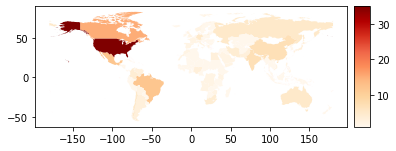

In [9]:
df = groupedresult.toPandas()
gdf = gpd.GeoDataFrame(df, geometry="country_geom")

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
fig, ax = plt.subplots(1, 1)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

gdf.plot(
    column="AirportCount",
    legend=True,
    cmap='OrRd',
    cax=cax,
    ax=ax
)